In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline


from scipy import interpolate

In [2]:
# in this case we're going to use tables from two different papers (Claret 2017, Claret 2018)
# in the first one, we have a theoretical model for the LD coefficients starting from TESS data, as a function of atm parameters
# on year later, he did the same thing but with a new method

# the goal here is to check whether they yield or not the same result
# the procedure is always the same as the two previous notebooks
# in both cases, we are going to fix metallicity

#let's consider the atmoshperic parameters for our target:
star_teff = [5400., 161.5]
star_logg = [4.5, 0.224] 
star_gfeh = [0.06, 0.108] 

star_gfeh = [0.00, 0.05] 
# Claret 2018 method works for zero metallicity, that's why we need to set gfeh=0 even though it's not the right metallicity

# Claret 2018 - [Fe/H]=0

In [3]:
# ADS: https://ui.adsabs.harvard.edu/abs/2018A%26A...618A..20C/abstract
# CDS: https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/618/A20

# table5.dat
#-------------------------------------------------------------------------------
#     Label Format Unit   Explanations
#-------------------------------------------------------------------------------
#      logg F5.2   cm/s+2 [2.5/6.0] Surface gravity
#      Teff F6.0   K      [1500/12000] Effective temperature
#         Z F4.1   [-]    [0] Metallicity (log[M/H])
#      L/HP F4.1   ---    [2] Mixing-length parameter
#         a F8.4   ---    Eq.2 spherical linear limb darkening coefficient
#                          a (FSM) (2)
#         b F8.4   ---    Eq.2 spherical linear limb darkening coefficient
#                          b (FSM) (2)
#        mu F8.4   ---    MU_CRI_ parameter (FSM)
#      chi2 F8.4   ---    SQRT(CHI2Q) (FSM)
#       Mod A2     ---    [PD PC] Model name (G1)
#       Sys A6     ---    System (TESS, KEPLER, COROT or MOST)
#-------------------------------------------------------------------------------
#Note (2): Eq. 2 : Quadratic law    I({mu})/I(1) = 1-a(1-{mu})-b(1-{mu})^2^
#-------------------------------------------------------------------------------

# values are  read as real double
table5 = np.genfromtxt('Claret2018_table5.dat',dtype=np.double)

logg = table5[:,0]
teff = table5[:,1]
lfeh = table5[:,2]
ld_c1 = table5[:,4]
ld_c2 = table5[:,5]

# let's print a bunch of numbers
print('logg: ',logg[:10])
print('Teff: ',teff[:10])
print('LD c1:',ld_c1[:10])
print('LD c2:',ld_c2[:10])

print()
print('logg # values: ',len(logg[teff==6000.]))
print('teff # values: ',len(teff[logg==4.0]))
print('array size: ',len(logg))
print('{0:.0f} x {1:.0f} = {2:.0f}'.format(len(logg[teff==6000.]), len(teff[logg==4.0]), len(logg)))

# We have three columns that we have to convert to a 2D grid - x, y ,z 
# Fortunately, the file is well formatted - we have a total of 8 values 
# for log(g) for each of 72 values for temperature

# 2.50  2300.  0.0  2.0   0.3720   0.5002   0.1220   0.1678 PC TESS
# 3.00  2300.  0.0  2.0   0.3825   0.4852   0.0849   0.1785 PC TESS
# 3.50  2300.  0.0  2.0   0.4348   0.4310   0.0663   0.1413 PC TESS
# 4.00  2300.  0.0  2.0   0.4840   0.3958   0.0502   0.1122 PC TESS

print()
logg_array = logg[teff==6200]
print('logg coordinates (array): ',logg_array)
teff_array = teff[logg==4.5]
print('Teff coordinates (array): ',teff_array)



logg:  [2.5 3.  3.5 4.  4.5 5.  5.5 6.  2.5 3. ]
Teff:  [2300. 2300. 2300. 2300. 2300. 2300. 2300. 2300. 2400. 2400.]
LD c1: [0.372  0.3825 0.4348 0.484  0.5076 0.5221 0.4719 0.4484 0.3324 0.3406]
LD c2: [0.5002 0.4852 0.431  0.3958 0.3676 0.3406 0.3577 0.3693 0.5118 0.4912]

logg # values:  8
teff # values:  72
array size:  574
8 x 72 = 574

logg coordinates (array):  [2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
Teff coordinates (array):  [ 2300.  2400.  2500.  2600.  2700.  2800.  2900.  3000.  3100.  3200.
  3300.  3400.  3500.  3600.  3700.  3800.  3900.  4000.  4100.  4200.
  4300.  4400.  4500.  4600.  4700.  4800.  4900.  5100.  5200.  5300.
  5400.  5500.  5600.  5700.  5800.  5900.  6000.  6100.  6200.  6300.
  6400.  6500.  6600.  6700.  6800.  6900.  7000.  7200.  7400.  7600.
  7800.  8000.  8200.  8400.  8600.  8800.  9000.  9200.  9400.  9600.
  9800. 10000. 10200. 10400. 10600. 10800. 11000. 11200. 11400. 11600.
 11800. 12000.]


Matrix shape:  (8, 72)
No value for (logg,teff)=(5.000000,3000.000000)
No value for (logg,teff)=(6.000000,2800.000000)


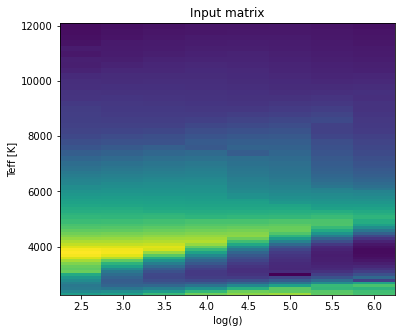

In [4]:
# we create a 2D grid with size (len(logg_array) x len(teff_array))
# for each LD coefficient

c1_matrix = np.zeros((len(logg_array), len(teff_array)))
c2_matrix = np.zeros((len(logg_array), len(teff_array)))
print('Matrix shape: ',np.shape(c1_matrix))

for logg_i, logg_v in enumerate(logg_array):
    for teff_i, teff_v in enumerate(teff_array):
        
        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (logg == logg_v) & (teff == teff_v)
        
        if np.sum(sel) == 1:
            c1_matrix[logg_i, teff_i] = ld_c1[sel]
            c2_matrix[logg_i, teff_i] = ld_c2[sel]
        else:
            print('No value for (logg,teff)=({0:f},{1:f})'.format(logg_v,teff_v))
            if teff_i==0:
                c1_matrix[logg_i, teff_i] = c1_matrix[logg_i, teff_i+1]
                c2_matrix[logg_i, teff_i] = c2_matrix[logg_i, teff_i+1]
            elif teff_i == len(teff_array)-1:
                c1_matrix[logg_i, teff_i] = c1_matrix[logg_i, teff_i-1]
                c2_matrix[logg_i, teff_i] = c2_matrix[logg_i, teff_i-1]
            else:
                c1_matrix[logg_i, teff_i] = (c1_matrix[logg_i, teff_i-1] + c1_matrix[logg_i, teff_i+1])/2
                c2_matrix[logg_i, teff_i] = (c2_matrix[logg_i, teff_i-1] + c2_matrix[logg_i, teff_i+1])/2
                # replacing this combination with average values


# Le't see the "real" matrix
xx, yy = np.meshgrid(logg_array,teff_array)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix.T, shading='auto')
plt.title('Input matrix')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

input: logg=3.000000, teff=6100.000000, c1: in=0.351900 out=0.351900 c2: in=0.248700 out=0.248700
input: logg=3.000000, teff=6200.000000, c1: in=0.343700 out=0.343700 c2: in=0.253600 out=0.253600
input: logg=3.400000, teff=6120.000000, c1: in=0.351900 out=0.351204 c2: in=0.248700 out=0.231584


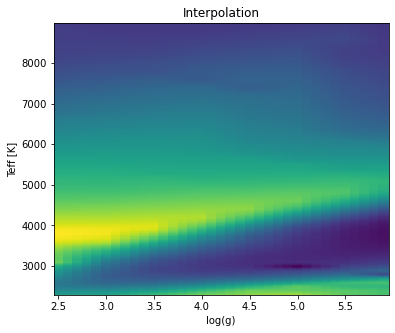

In [5]:
# bilinear_interpolation usci Scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

# Note: if len(logg_array)=m and len(teff_array)=n, the third array must be n*m 
c1_function = interpolate.interp2d(logg_array, teff_array, c1_matrix.T, kind='linear')
c2_function = interpolate.interp2d(logg_array, teff_array, c2_matrix.T, kind='linear')

# checking with some parameters... it's always good to check!!!
ii = 295
teff_in = teff[ii]
logg_in = logg[ii]
c1_in = ld_c1[ii]
c2_in = ld_c2[ii]

c1_out = c1_function(logg_in, teff_in)[0]
c2_out = c2_function(logg_in, teff_in)[0]
print('input: logg={0:f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))

teff_in = teff[ii+8]
logg_in = logg[ii+8]
c1_in = ld_c1[ii+8]
c2_in = ld_c2[ii+8]

c1_out = c1_function(logg_in, teff_in)[0]
c2_out = c2_function(logg_in, teff_in)[0]
print('input: logg={0:4f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))

# let's see what happens if we take a value in temperature between the two above, and a value ini gravity sliglty different:
teff_in = teff[ii] + 20
logg_in = logg[ii] + 0.4
c1_in = ld_c1[ii]
c2_in = ld_c2[ii]

c1_out = c1_function(logg_in, teff_in)[0]
c2_out = c2_function(logg_in, teff_in)[0]
print('input: logg={0:f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))
# look at the output value!!

teff_grid = np.arange(2300, 9000, 25)
logg_grid = np.arange(2.5, 6.0, 0.1)

xx, yy = np.meshgrid(logg_grid,teff_grid)
c1_plot_out = c1_function(logg_grid, teff_grid)

plt.figure(figsize=(6,5))
plt.pcolor(xx,yy, c1_plot_out, shading='auto')
plt.title('Interpolation')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

# Claret 2017 - stellar metallicity

In [6]:
# ADS: https://ui.adsabs.harvard.edu/abs/2017A%26A...600A..30C/abstract
# CDS: https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/600/A30


#!form=a
#${logg} ${Teff} ${Z} ${xi} ${aLSM} ${bLSM} ${aPCM} ${bPCM} ${chi2} ${Mod}
# (hit Return)
## (from tabmap V6.0 (2016-08-18)) 2020-12-08T20:14:03
#---------------------------------------------------------------------------
#-- J/A+A/600/A30 Limb-darkening for TESS satellite (Claret, 2017)
#--------------------------------------------------------------------------
#---Table: J/A+A/600/A30/table25.dat.gz a, b quadratic LDCs, ATLAS models, all metallicities, v.tu=0,1,2,4,8 km/s for TESS (LSM, PCM)  (9586 records)
#-------------------------------------------------------------------------------
#     Label Format Unit    Explanations
#-------------------------------------------------------------------------------
#      logg F5.2   [cm/s2] [0.0/5.0] Surface gravity
#      Teff F6.0   K       [3500/50000] Effective temperature
#         Z F4.1   [Sun]   [-5.0/1.0] Metallicity (log[M/H])
#        xi F3.1   km/s    [0/8] Microturbulent velocity {xi}
#      aLSM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS LSM) (G2)
#      bLSM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS LSM) (G2)
#      aPCM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS FCM) (G2)
#      bPCM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS FCM) (G2)
#      chi2 F6.4   ---     SQRT(CHI2Q) (TESS LSM)
#       Mod A2     ---     [PD PC A] Model name (G3)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------
#table15 = np.genfromtxt('table15_claret2017.dat',dtype=np.double)

table25 = np.genfromtxt('Claret2017_table25.dat',dtype=np.double)

# Reference metallicity: [Fe/H]=0.0 


# pick the closest value to stellar metallicity
# we only selected the row with microturbulent velocity equal to 2.0 km/s
feh_ind = np.argmin(np.abs(table25[:,2]-star_gfeh[0])) # fixing metallicity to the one of the target star
print('Selected metallicity from the table: ', table25[feh_ind,2])
feh_sel = (table25[:,2] == table25[feh_ind,2]) & (table25[:,3] == 2.0 )

logg_c2017 = table25[feh_sel,0]
teff_c2017 = table25[feh_sel,1]
lfeh_c2017 = table25[feh_sel,2]
ld_c1_c2017 = table25[feh_sel,4]
ld_c2_c2017 = table25[feh_sel,5]

# let's print a bunch of numbers
print('logg: ',logg_c2017[:10])
print('Teff: ',teff_c2017[:10])
print('LD c1:',ld_c1_c2017[:10])
print('LD c2:',ld_c2_c2017[:10])

print()
print('logg # values: ',len(logg_c2017[teff_c2017==6000.]))
print('teff # values: ',len(teff_c2017[logg_c2017==4.0]))
print('array size: ',len(logg_c2017))
print('{0:.0f} x {1:.0f} = {2:.0f}'.format(len(logg_c2017[teff_c2017==6000.]), len(teff_c2017[logg_c2017==4.0]), len(logg_c2017)))

# We have three columns that we have to convert to a 2D grid - x, y ,z 
# Fortunately, the file is well formatted - we have a total of 8 values 
# for log(g) for each of 72 values for temperature

# 2.50  2300.  0.0  2.0   0.3720   0.5002   0.1220   0.1678 PC TESS
# 3.00  2300.  0.0  2.0   0.3825   0.4852   0.0849   0.1785 PC TESS
# 3.50  2300.  0.0  2.0   0.4348   0.4310   0.0663   0.1413 PC TESS
# 4.00  2300.  0.0  2.0   0.4840   0.3958   0.0502   0.1122 PC TESS

print()

# avoid extreme gravities and temperatures
sel_logg = (teff_c2017==6000) & (logg_c2017 > 3.0)
sel_teff = (logg_c2017==4.5) & (teff_c2017 < 9500.0)

logg_array_c2017 = logg_c2017[sel_logg]
print('logg coordinates (array): ',logg_array_c2017)
teff_array_c2017 = teff_c2017[sel_teff]
print('Teff coordinates (array): ',teff_array_c2017)



Selected metallicity from the table:  0.0
logg:  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
Teff:  [3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500.]
LD c1: [0.7094 0.7    0.6869 0.6721 0.6573 0.6432 0.6169 0.5206 0.3934 0.3109]
LD c2: [0.0523 0.0489 0.0492 0.0518 0.0557 0.0612 0.0809 0.1676 0.277  0.3446]

logg # values:  11
teff # values:  65
array size:  476
11 x 65 = 476

logg coordinates (array):  [3.5 4.  4.5 5. ]
Teff coordinates (array):  [3500. 3750. 4000. 4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250.
 6500. 6750. 7000. 7250. 7500. 7750. 8000. 8250. 8500. 8750. 9000. 9250.]


Matrix shape:  (4, 24)


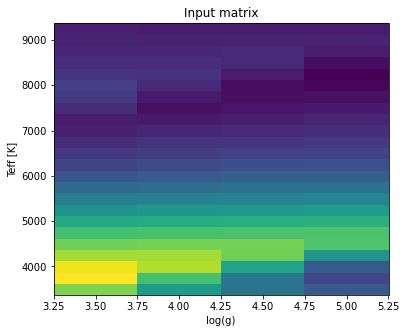

In [7]:
# we create a 2D grid with size (len(logg_array) x len(teff_array))
# for each LD coefficient

c1_matrix_c2017 = np.zeros((len(logg_array_c2017), len(teff_array_c2017)))
c2_matrix_c2017 = np.zeros((len(logg_array_c2017), len(teff_array_c2017)))
print('Matrix shape: ',np.shape(c1_matrix_c2017))

for logg_i, logg_v in enumerate(logg_array_c2017):
    for teff_i, teff_v in enumerate(teff_array_c2017):
        
        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (logg_c2017 == logg_v) & (teff_c2017 == teff_v)
        
        if np.sum(sel) == 1:
            c1_matrix_c2017[logg_i, teff_i] = ld_c1_c2017[sel]
            c2_matrix_c2017[logg_i, teff_i] = ld_c2_c2017[sel]
        else:
            print('No value for (logg,teff)=({0:f},{1:f})'.format(logg_v,teff_v))
            if teff_i==0:
                c1_matrix_c2017[logg_i, teff_i] = c1_matrix_c2017[logg_i, teff_i+1]
                c2_matrix_c2017[logg_i, teff_i] = c2_matrix_c2017[logg_i, teff_i+1]
            elif teff_i == len(teff_array_c2017)-1:
                c1_matrix_c2017[logg_i, teff_i] = c1_matrix_c2017[logg_i, teff_i-1]
                c2_matrix_c2017[logg_i, teff_i] = c2_matrix_c2017[logg_i, teff_i-1]
            else:
                c1_matrix_c2017[logg_i, teff_i] = (c1_matrix_c2017[logg_i, teff_i-1] + c1_matrix_c2017[logg_i, teff_i+1])/2
                c2_matrix_c2017[logg_i, teff_i] = (c2_matrix_c2017[logg_i, teff_i-1] + c2_matrix_c2017[logg_i, teff_i+1])/2
                # replacing this combination with average values
            

# Le't see the "real" matrix
xx, yy = np.meshgrid(logg_array_c2017,teff_array_c2017)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_c2017.T, shading='auto')
plt.title('Input matrix')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

input: logg=2.000000, teff=11500.000000, c1: in=0.133700 out=0.166000 c2: in=0.313100 out=0.260300
input: logg=2.500000, teff=11750.000000, c1: in=0.119900 out=0.166000 c2: in=0.288800 out=0.260300
input: logg=2.400000, teff=11520.000000, c1: in=0.133700 out=0.166000 c2: in=0.313100 out=0.260300


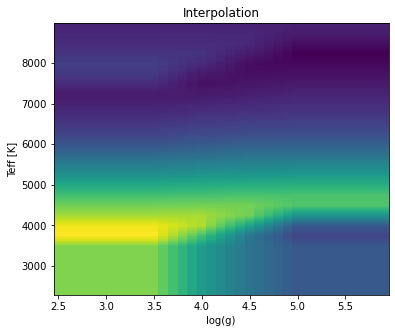

In [8]:
# bilinear_interpolation usci Scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

# Note: if len(logg_array)=m and len(teff_array)=n, the third array must be n*m 
c1_function_c2017 = interpolate.interp2d(logg_array_c2017, teff_array_c2017, c1_matrix_c2017.T, kind='linear')
c2_function_c2017 = interpolate.interp2d(logg_array_c2017, teff_array_c2017, c2_matrix_c2017.T, kind='linear')

# checking with some parameters... it's always good to check!!!
ii = 295
teff_in = teff_c2017[ii]
logg_in = logg_c2017[ii]
c1_in = ld_c1_c2017[ii]
c2_in = ld_c2_c2017[ii]

c1_out = c1_function_c2017(logg_in, teff_in)[0]
c2_out = c2_function_c2017(logg_in, teff_in)[0]
print('input: logg={0:f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))

teff_in = teff_c2017[ii+8]
logg_in = logg_c2017[ii+8]
c1_in = ld_c1_c2017[ii+8]
c2_in = ld_c2_c2017[ii+8]

c1_out = c1_function_c2017(logg_in, teff_in)[0]
c2_out = c2_function_c2017(logg_in, teff_in)[0]
print('input: logg={0:4f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))

# let's see what happens if we take a value in temperature between the two above, and a value ini gravity sliglty different:
teff_in = teff_c2017[ii] + 20
logg_in = logg_c2017[ii] + 0.4
c1_in = ld_c1_c2017[ii]
c2_in = ld_c2_c2017[ii]

c1_out = c1_function_c2017(logg_in, teff_in)[0]
c2_out = c2_function_c2017(logg_in, teff_in)[0]
print('input: logg={0:f}, teff={1:f}, c1: in={2:f} out={3:f} c2: in={4:f} out={5:f}'.format(logg_in, teff_in, c1_in, c1_out, c2_in, c2_out))
# look at the output value!!

teff_grid = np.arange(2300, 9000, 25)
logg_grid = np.arange(2.5, 6.0, 0.1)

xx, yy = np.meshgrid(logg_grid,teff_grid)
c1_plot_out = c1_function_c2017(logg_grid, teff_grid)

plt.figure(figsize=(6,5))
plt.pcolor(xx,yy, c1_plot_out, shading='auto')
plt.title('Interpolation')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

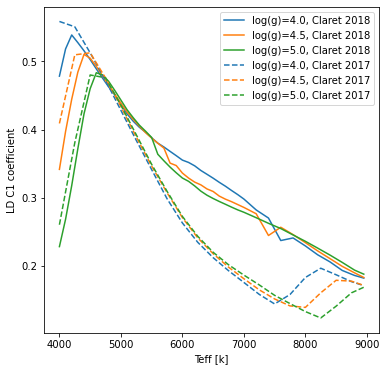

In [9]:
teff_curve = np.arange(4000,9000,50)
c1_logg40 = c1_function(4.0, teff_curve)
c1_logg45 = c1_function(4.5, teff_curve)
c1_logg50 = c1_function(5.0, teff_curve)

c1_logg40_c2017 = c1_function_c2017(4.0, teff_curve)
c1_logg45_c2017 = c1_function_c2017(4.5, teff_curve)
c1_logg50_c2017 = c1_function_c2017(5.0, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c1_logg40, c='C0', label='log(g)=4.0, Claret 2018')
plt.plot(teff_curve, c1_logg45, c='C1', label='log(g)=4.5, Claret 2018')
plt.plot(teff_curve, c1_logg50, c='C2', label='log(g)=5.0, Claret 2018')
plt.plot(teff_curve, c1_logg40_c2017, c='C0', linestyle='--', label='log(g)=4.0, Claret 2017')
plt.plot(teff_curve, c1_logg45_c2017, c='C1', linestyle='--', label='log(g)=4.5, Claret 2017')
plt.plot(teff_curve, c1_logg50_c2017, c='C2', linestyle='--', label='log(g)=5.0, Claret 2017')
plt.ylabel('LD C1 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

see how the choice for the models affects the coefficient. In this paper we used a different model and we see a stronger dependance on gravity with respect to the previous notebooks.

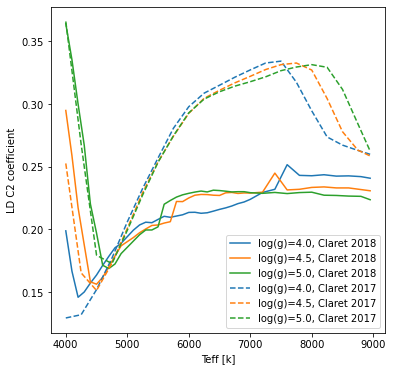

In [10]:
teff_curve = np.arange(4000,9000,50)
c2_logg40 = c2_function(4.0, teff_curve)
c2_logg45 = c2_function(4.5, teff_curve)
c2_logg50 = c2_function(5.0, teff_curve)

c2_logg40_c2017 = c2_function_c2017(4.0, teff_curve)
c2_logg45_c2017 = c2_function_c2017(4.5, teff_curve)
c2_logg50_c2017 = c2_function_c2017(5.0, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c2_logg40, c='C0', label='log(g)=4.0, Claret 2018')
plt.plot(teff_curve, c2_logg45, c='C1', label='log(g)=4.5, Claret 2018')
plt.plot(teff_curve, c2_logg50, c='C2', label='log(g)=5.0, Claret 2018')
plt.plot(teff_curve, c2_logg40_c2017, c='C0', linestyle='--', label='log(g)=4.0, Claret 2017')
plt.plot(teff_curve, c2_logg45_c2017, c='C1', linestyle='--', label='log(g)=4.5, Claret 2017')
plt.plot(teff_curve, c2_logg50_c2017, c='C2', linestyle='--', label='log(g)=5.0, Claret 2017')
plt.ylabel('LD C2 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

In [11]:
teff_in = star_teff[0]
logg_in = star_logg[0]
c1_star = c1_function(logg_in, teff_in)[0]
c2_star = c2_function(logg_in, teff_in)[0]
print('Claret 2018: logg={0:f}, teff={1:f}, c1={2:f} c2={3:f}'.format(logg_in, teff_in, c1_star, c2_star))


teff_in = star_teff[0]
logg_in = star_logg[0]
c1_star_c2017 = c1_function_c2017(logg_in, teff_in)[0]
c2_star_c2017 = c2_function_c2017(logg_in, teff_in)[0]
print('Claret 2017: logg={0:f}, teff={1:f}, c1={2:f} c2={3:f}'.format(logg_in, teff_in, c1_star_c2017, c2_star_c2017))

Claret 2018: logg=4.500000, teff=5400.000000, c1=0.395600 c2=0.203200
Claret 2017: logg=4.500000, teff=5400.000000, c1=0.363480 c2=0.244000


In [12]:
# Let'r try again with a lot more of samples
n_sample = 100000  # start small (1000) and increase the number while execution time is still acceptable
teff_dist = np.random.normal(star_teff[0], star_teff[1], n_sample)
logg_dist = np.random.normal(star_logg[0], star_logg[1], n_sample)

# let's do it the slow - but safe - way
c1_dist = np.zeros(n_sample)
c2_dist = np.zeros(n_sample)
c1_dist_c2017 = np.zeros(n_sample)
c2_dist_c2017 = np.zeros(n_sample)
for ii in range(0, n_sample):
    c1_dist[ii] = c1_function(logg_dist[ii], teff_dist[ii])
    c2_dist[ii] = c2_function(logg_dist[ii], teff_dist[ii])
    c1_dist_c2017[ii] = c1_function_c2017(logg_dist[ii], teff_dist[ii])
    c2_dist_c2017[ii] = c2_function_c2017(logg_dist[ii], teff_dist[ii])
    

number of samples: 100000   shape of the array: (100000,)



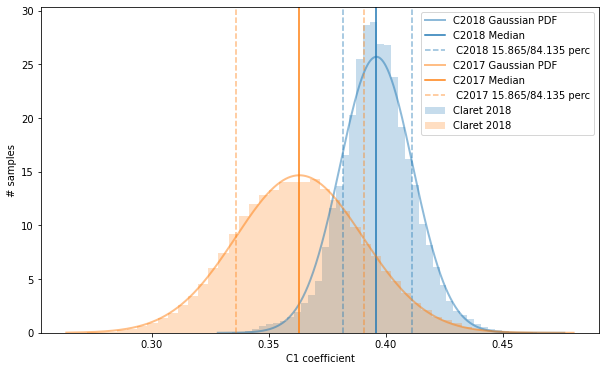

2017 Median:   0.36312472227346754 +- 0.027206035115585045
2018 Median:   0.39605113076753573 +- 0.015526842168611606


In [13]:
print('number of samples:',len(c1_dist),'  shape of the array:', c1_dist.shape)

print()
c1_average = np.average(c1_dist) # average
c1_median = np.median(c1_dist)   # median
c1_std = np.std(c1_dist)         # standard deviation
c1_minus1sigma_perc = np.percentile(c1_dist, 15.865)
c1_plus1sigma_perc = np.percentile(c1_dist, 84.135)

c1_c2017_average = np.average(c1_dist_c2017) # average
c1_c2017_median = np.median(c1_dist_c2017)   # median
c1_c2017_std = np.std(c1_dist_c2017)         # standard deviation
c1_c2017_minus1sigma_perc = np.percentile(c1_dist_c2017, 15.865)
c1_c2017_plus1sigma_perc = np.percentile(c1_dist_c2017, 84.135)


# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c1_dist, 50, density=True, label='Claret 2018', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c1_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c1_median)**2 / (2 *  c1_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='C2018 Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c1_median,  c='C0', label='C2018 Median')
plt.axvline(c1_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label=' C2018 15.865/84.135 perc')
plt.axvline(c1_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')

count, bins, _ = plt.hist(c1_dist_c2017, 50, density=True, label='Claret 2018', alpha=0.25, color='C1')
x_gauss = np.linspace(bins[0], bins[-1], 1000)

y_gauss = 1/( c1_c2017_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c1_c2017_median)**2 / (2 *  c1_c2017_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='C2017 Gaussian PDF',  color='C1', alpha=0.5)

plt.axvline(c1_c2017_median,  c='C1', label='C2017 Median')
plt.axvline(c1_c2017_minus1sigma_perc, alpha=0.5, c='C1', linestyle='--', label=' C2017 15.865/84.135 perc')
plt.axvline(c1_c2017_plus1sigma_perc , alpha=0.5, c='C1', linestyle='--')


plt.xlabel('C1 coefficient')
plt.ylabel('# samples')
plt.legend()
plt.show()

print("2017 Median:  ", c1_c2017_median, "+-", c1_c2017_std)
print("2018 Median:  ", c1_median, "+-", c1_std)


the two values are quite different even in terms of error. This indicates a systematic difference cause by the choice of the model. Because of this, we need to artificially inflate the error before using limb darkening parameters. This is very important for shallow transits.

number of samples: 100000   shape of the array: (100000,)

2017 Median:   0.24441657816105805 +- 0.01570285841592971
2018 Median:   0.20296648417964785 +- 0.004844562181704564


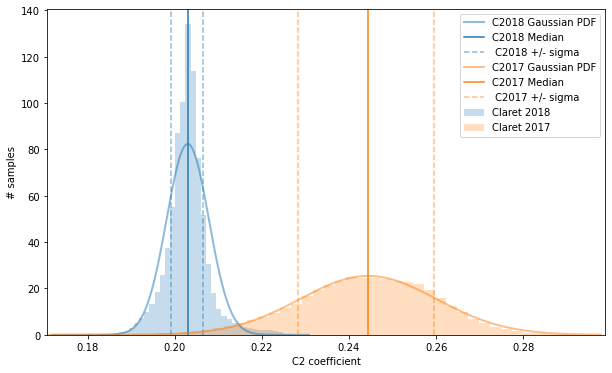

In [14]:
print('number of samples:',len(c2_dist),'  shape of the array:', c2_dist.shape)

print()
c2_average = np.average(c2_dist) # average
c2_median = np.median(c2_dist)   # median
c2_std = np.std(c2_dist)         # standard deviation
c2_minus1sigma_perc = np.percentile(c2_dist, 15.865)
c2_plus1sigma_perc = np.percentile(c2_dist, 84.135)

c2_c2017_average = np.average(c2_dist_c2017) # average
c2_c2017_median = np.median(c2_dist_c2017)   # median
c2_c2017_std = np.std(c2_dist_c2017)         # standard deviation
c2_c2017_minus1sigma_perc = np.percentile(c2_dist_c2017, 15.865)
c2_c2017_plus1sigma_perc = np.percentile(c2_dist_c2017, 84.135)


# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c2_dist, 50, density=True, label='Claret 2018', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c2_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c2_median)**2 / (2 *  c2_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='C2018 Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c2_median,  c='C0', label='C2018 Median')
plt.axvline(c2_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label=' C2018 +/- sigma')
plt.axvline(c2_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')

count, bins, _ = plt.hist(c2_dist_c2017, 50, density=True, label='Claret 2017', alpha=0.25, color='C1')
x_gauss_c2017 = np.linspace(bins[0], bins[-1], 1000)

y_gauss_c2017 = 1/( c2_c2017_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss_c2017 - c2_c2017_median)**2 / (2 *  c2_c2017_std**2) )
plt.plot(x_gauss_c2017, y_gauss_c2017, linewidth=2, label='C2017 Gaussian PDF',  color='C1', alpha=0.5)

plt.axvline(c2_c2017_median,  c='C1', label='C2017 Median')
plt.axvline(c2_c2017_minus1sigma_perc, alpha=0.5, c='C1', linestyle='--', label=' C2017 +/- sigma')
plt.axvline(c2_c2017_plus1sigma_perc , alpha=0.5, c='C1', linestyle='--')


plt.xlim(min(x_gauss[0],x_gauss_c2017[0]), max(x_gauss[-1],x_gauss_c2017[-1])+0.001)
plt.xlabel('C2 coefficient')
plt.ylabel('# samples')
plt.legend(loc='upper right')
plt.savefig('Claret2018_Claret2017_C2_comparison', bbox_inches='tight')

print("2017 Median:  ", c2_c2017_median, "+-", c2_c2017_std)
print("2018 Median:  ", c2_median, "+-", c2_std)



     median     : 0.2435
     std        : 0.0073
     15.865 perc: 0.2377
     84.135 perc: 0.2524
     
     -1 sigma : 0.2435-0.2377=0.006
     +1 sigma : 0.2524-0.2435=0.009
     
     We took the xx percentiles as an estimate of the confidence interval
     $0.2435_{-0.006}^{+0.009}$ 

    In the code:
        -> Try the fit without any prior on limb darkening 
        -> Compare the results with your estimate distribution
        
        -> Are they consistent? If consistent: try the fit with the priors 
            -> provide the actual file the all the samples values 
            -> or provide a Gaussian prior with conservative estimate of the variance 
                Gaussian 0.244 STD: 0.009 
            Is the precision of the planetary radius improved? 
           
           
            
